In [1]:
!pip --quiet install tqdm

In [2]:
!pip --quiet install textblob vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.3 MB/s eta 0:00:00


In [3]:
!pip --quiet install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()  # Register tqdm for pandas

In [6]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## Download Dataset from Kaggle

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kazanova/sentiment140")

print("Path to dataset files:", path)

100%|██████████| 80.9M/80.9M [00:00<00:00, 118MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kazanova/sentiment140/versions/2


In [8]:
ls /root/.cache/kagglehub/datasets/kazanova/sentiment140/versions/2

training.1600000.processed.noemoticon.csv


In [9]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"] # Initialize column name because they are not present in the original data
DATASET_ENCODING = "ISO-8859-1" # Entire data is not UTF-8 Encoding so there is need to specify encoding

In [10]:
df = pd.read_csv(path+"/training.1600000.processed.noemoticon.csv", names=DATASET_COLUMNS, encoding=DATASET_ENCODING)

In [11]:
df.shape

(1600000, 6)

In [12]:
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

## Data Cleaning

This step cleans the dataset of unwanted texts(rows).

In [13]:
df['target'].value_counts()

,count
target,
0,800000
4,800000


Target column contains two values 0 and 4. The description on [kaggle](https://www.kaggle.com/datasets/kazanova/sentiment140/data) states that:<br>
0 - Negative<br>
4 - Positive

In [14]:
# Change target value for positive to 1 instead of 4 because some models benefit from normalized targets
df['target'] = df['target'].replace({4: 1})
df['target'].value_counts()

,count
target,
0,800000
1,800000


In [15]:
# Check if text are null
df['text'].isnull().sum()

np.int64(0)

In [16]:
# Check for duplicate tweets
df['text'].duplicated().sum()

np.int64(18534)

In [17]:
# Remove duplicates from dataset
print (f'Shape of df before removing duplicates: {df.shape}')
df.drop_duplicates(subset='text', inplace=True)
print (f'Shape of df after removing duplicates: {df.shape}')

Shape of df before removing duplicates: (1600000, 6)
Shape of df after removing duplicates: (1581466, 6)


In [18]:
df['target'].value_counts()

,count
target,
1,791281
0,790185


In [19]:
# Check to see if text is less than 3 characters
df[df['text'].str.len() < 3].shape[0]

0

In [20]:
# Check for Non-ASCII characters in Tweets
df[df['text'].apply(lambda x: any(ord(c) > 127 for c in x))].shape[0]

14436

In [21]:
non_ascii_texts = df[df['text'].apply(lambda x: any(ord(c) > 127 for c in x))]
non_ascii_std_chars = set()
for i, row in non_ascii_texts.iterrows():
    for c in row['text']:
        if ord(c) > 127:
            non_ascii_std_chars.add(c)

print (non_ascii_std_chars)

{'ä', 'Ê', '\x8c', 'Í', 'Â', '¡', '\x80', '\x9f', '«', '¯', '½', '\x99', 'Ë', 'ç', 'æ', '\x8b', '¿', 'ê', 'Æ', '¬', 'Ò', '\x9e', 'Û', '\x89', 'Ù', '£', 'É', 'é', 'Ä', '¸', '¨', '·', 'è', 'È', 'ã', '\x8a', '´', '\x94', '\x86', '\x83', 'ª', '\x85', '°', '¥', '\x88', '±', 'Î', '\x93', '×', 'Ó', 'Ð', '\x9c', '\x98', '®', 'ß', '¶', '¼', '\x9b', 'Å', '¢', '¾', '\x9a', 'Ï', '¦', 'á', '©', '\x92', 'ï', 'Ã', 'ì', '\x8e', '¤', '\xad', 'ë', '³', 'å', 'í', 'Ì', '»', 'à', 'î', 'Ç', '\x95', '\x82', 'µ', '\x91', 'â', '\x96', 'Ú', '\x87', '¹', 'Ø', '\xa0', 'Ñ', '\x84', 'º', '²', '§', '\x97'}


In [22]:
# Removing texts containing characters from other languages
# Effectively only including upper and lower case, punctuations, and numbers
df = df[df['text'].apply(lambda x: all(ord(c) < 128 for c in str(x)))]
print (f"Shape after removing rows: {df.shape}")

Shape after removing rows: (1567030, 6)


In [23]:
df['target'].value_counts()

,count
target,
0,784365
1,782665


## Text Preprocessing

Text Preprocessing performs transformations at the text level<br>
This includes the following steps<br>
<ol>
<li>Remove Twitter Elements: "@Username", "#Hashtags" and URLs</li>
<li>Remove Punctuations and Numbers</li>
<li>Strip remaning whitespace</li>
<li>Lowercase the characters</li>
<li>Tokenize the text into words</li>
<li>Remove the stopwords</li>
<li>Lemmetize the text (Convert words to their base form)</li>
<li>Join the list tokens to string of text</li>
</ol>

In [24]:
# Number of rows with @Username present in tweets
df[df['text'].str.contains(r'@\w+', regex=True, na=False)].shape[0]

729627

In [25]:
# Check "RT" for Retweet present in Tweet
df[df['text'].str.contains(r'\bRT\b', regex=True, na=False)].shape[0]

0

In [26]:
# Check for strings containing punctuations
df[df['text'].str.contains(r'[\W_]+', na=False)].shape[0]

1567030

In [27]:
# Check for Hashtags in Tweets
df[df['text'].str.contains(r'#\w+', regex=True, na=False)].shape[0]

34998

In [28]:
def preprocess_text(text):
    # 1. Remove mentions (@user)
    text = re.sub(r'@\w+', '', text)

    # 2. Replace hashtags: keep word, remove #
    text = re.sub(r'#(\w+)', r'\1', text)

    # 3. Remove URLs
    text = re.sub(r'(https?://\S+|www\.\S+)', '', text)

    # 4. Lowercase
    text = text.lower()

    # 5. Remove punctuation (except emojis and non-ASCII if needed)
    text = re.sub(r'[^\w\s]', '', text)

    # 6. Remove numbers
    text = re.sub(r'\d+', '', text)

    # 7. Tokenize
    tokens = nltk.word_tokenize(text)

    # 8. Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    # 9. Join tokens back
    return ' '.join(tokens)


In [29]:
df['text_processed'] = df['text'].progress_apply(preprocess_text)

100%|██████████| 1567030/1567030 [04:16<00:00, 6108.41it/s]


In [30]:
print (f"Original Text: {df['text'].iloc[0]}")
print (f"Preprocessed Text: {preprocess_text(df['text'].iloc[0])}")

Original Text: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
Preprocessed Text: awww thats bummer shoulda got david carr third day


## Data Visualization

In [31]:
df['target_label'] = df['target'].apply(lambda x: "Negative" if x == 0 else "Positive")

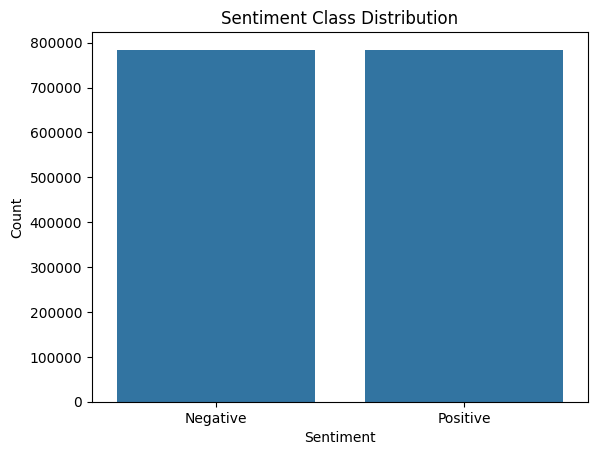

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='target', data=df)
plt.title("Sentiment Class Distribution")
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

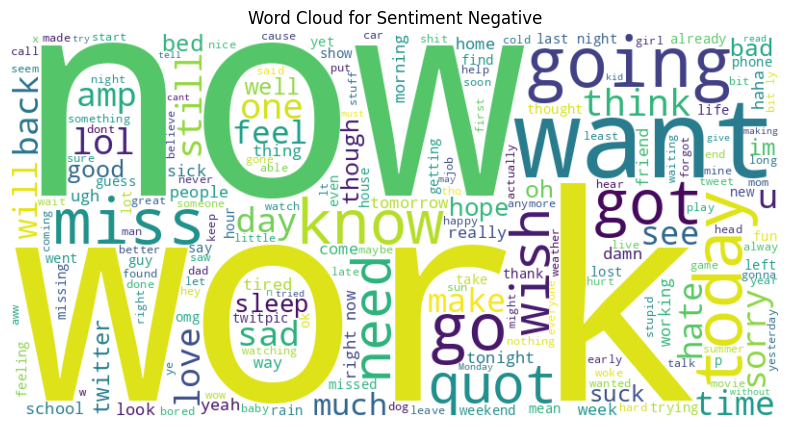

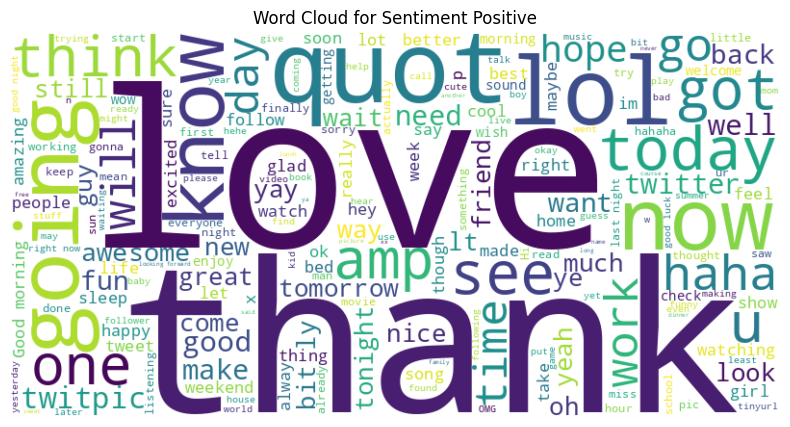

In [33]:
from wordcloud import WordCloud

for label in df['target_label'].unique():
    text = ' '.join(df[df['target_label'] == label]['text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Sentiment {label}")
    plt.show()

100%|██████████| 1567030/1567030 [01:59<00:00, 13078.15it/s]


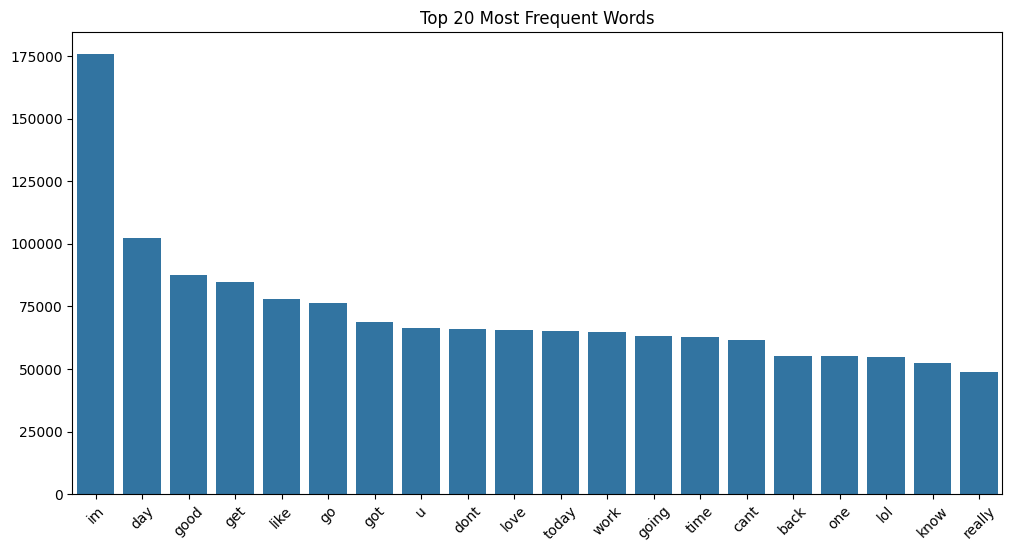

In [34]:
from collections import Counter

all_words = []

# Optional: use preprocessed text column
for text in tqdm(df['text_processed']):
    all_words.extend(nltk.word_tokenize(text.lower()))

# Count word frequencies
word_freq = Counter(all_words)
most_common = word_freq.most_common(20)

# Plot
words, counts = zip(*most_common)
plt.figure(figsize=(12, 6))
sns.barplot(x=list(words), y=list(counts))
plt.title("Top 20 Most Frequent Words")
plt.xticks(rotation=45)
plt.show()

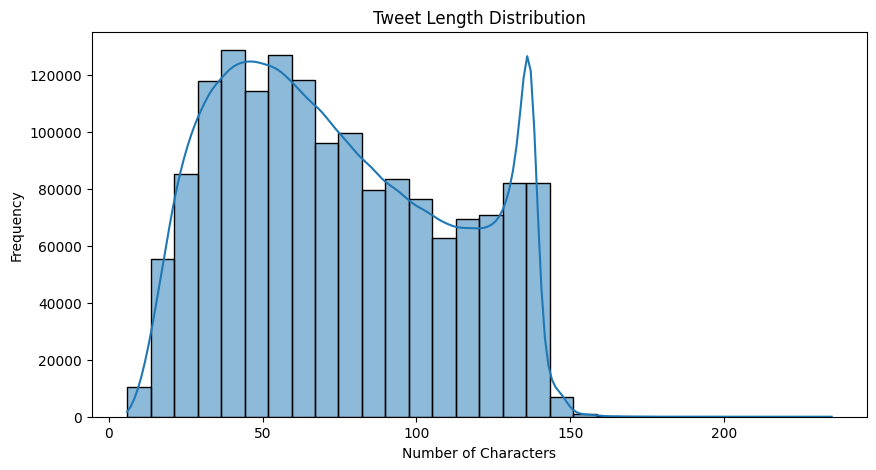

In [35]:
df['text_length'] = df['text'].apply(len)

plt.figure(figsize=(10, 5))
sns.histplot(df['text_length'], bins=30, kde=True)
plt.title("Tweet Length Distribution")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.show()

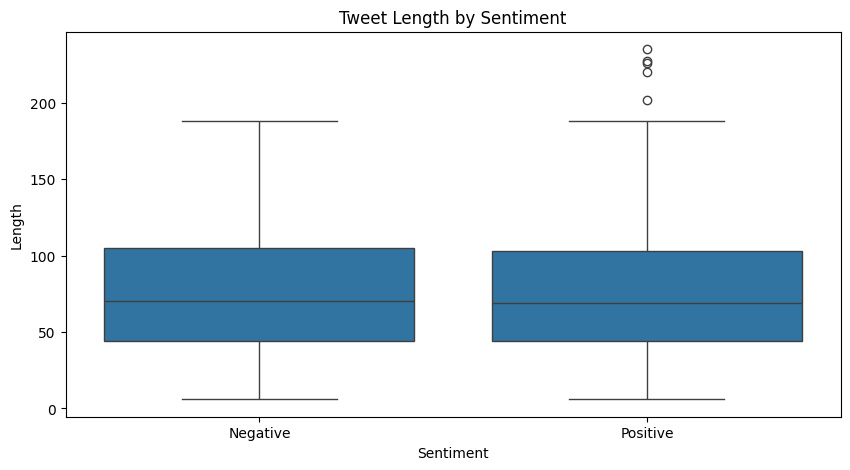

In [36]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='target', y='text_length', data=df)
plt.title("Tweet Length by Sentiment")
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.xlabel("Sentiment")
plt.ylabel("Length")
plt.show()

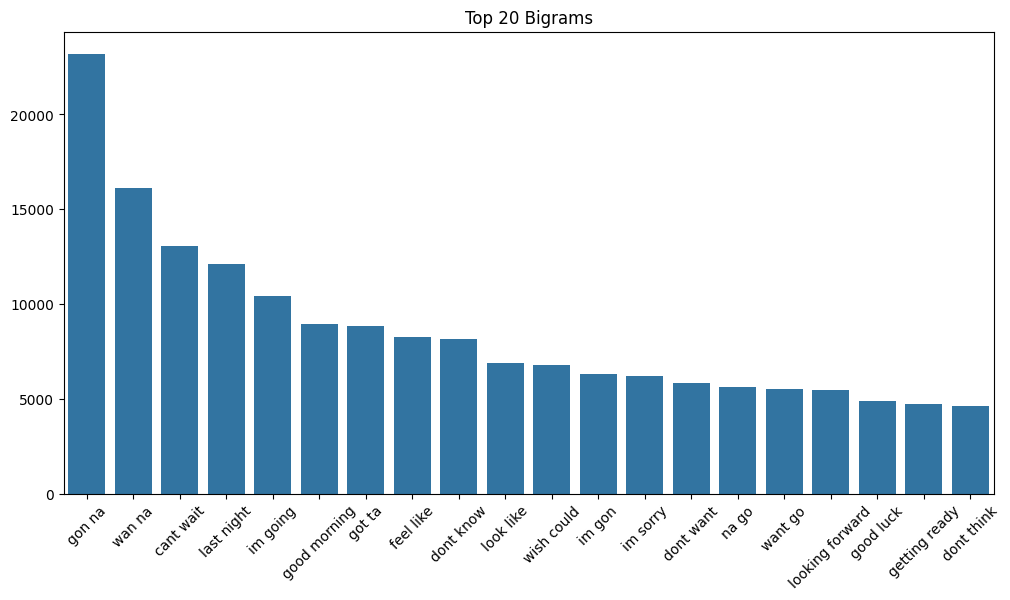

In [37]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(ngram_range=(2, 2), max_features=20)
X = cv.fit_transform(df['text_processed'])

# Sum frequencies
sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

# Plot
words, counts = zip(*words_freq)
plt.figure(figsize=(12, 6))
sns.barplot(x=list(words), y=list(counts))
plt.title("Top 20 Bigrams")
plt.xticks(rotation=45)
plt.show()

## Rule Based Models (Baseline Models)<br>
Rule-based sentiment models like TextBlob and VADER rely on predefined dictionaries (lexicons) where each word is associated with a polarity score (positive, negative, or neutral).
<ol>
<li>Text Blob</li>
<li>VADER</li>
</ol>

In [ ]:
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import classification_report, accuracy_score

# TextBlob polarity and prediction
df['textblob_polarity'] = df['text_processed'].progress_apply(lambda x: TextBlob(x).sentiment.polarity)
df['textblob_sentiment'] = df['textblob_polarity'].progress_apply(lambda x: 1 if x > 0 else 0)

# VADER sentiment analyzer
vader = SentimentIntensityAnalyzer()
df['vader_compound'] = df['text_processed'].progress_apply(lambda x: vader.polarity_scores(x)['compound'])
df['vader_sentiment'] = df['vader_compound'].progress_apply(lambda x: 1 if x >= 0 else 0)

100%|██████████| 1567030/1567030 [00:01<00:00, 1219432.14it/s]


In [ ]:
# TextBlob Evaluation
print("TextBlob Evaluation")
print(classification_report(df['target'], df['textblob_sentiment'], target_names=['Negative', 'Positive']))
print("Accuracy:", accuracy_score(df['target'], df['textblob_sentiment']))

# VADER Evaluation
print("\n VADER Evaluation")
print(classification_report(df['target'], df['vader_sentiment'], target_names=['Negative', 'Positive']))
print("Accuracy:", accuracy_score(df['target'], df['vader_sentiment']))

TextBlob Evaluation
              precision    recall  f1-score   support

    Negative       0.60      0.69      0.64    784365
    Positive       0.64      0.55      0.59    782665

    accuracy                           0.62   1567030
   macro avg       0.62      0.62      0.62   1567030
weighted avg       0.62      0.62      0.62   1567030

Accuracy: 0.6185982399826423

 VADER Evaluation
              precision    recall  f1-score   support

    Negative       0.79      0.39      0.52    784365
    Positive       0.59      0.90      0.71    782665

    accuracy                           0.64   1567030
   macro avg       0.69      0.64      0.62   1567030
weighted avg       0.69      0.64      0.62   1567030

Accuracy: 0.6427809295291093


## Machine Learning Models

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Limit features to reduce dimensionality (tune as needed)
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))

X = tfidf.fit_transform(df['text_processed'])
y = df['target']

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Logistic Regression

In [43]:
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [44]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

y_pred = logistic_model.predict(X_test)

# Classification metrics
print("Logistic Regression Results")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
print("Accuracy:", accuracy_score(y_test, y_pred))

Logistic Regression Results
              precision    recall  f1-score   support

    Negative       0.80      0.76      0.78    156873
    Positive       0.77      0.80      0.79    156533

    accuracy                           0.78    313406
   macro avg       0.78      0.78      0.78    313406
weighted avg       0.78      0.78      0.78    313406

Accuracy: 0.7822568808510367


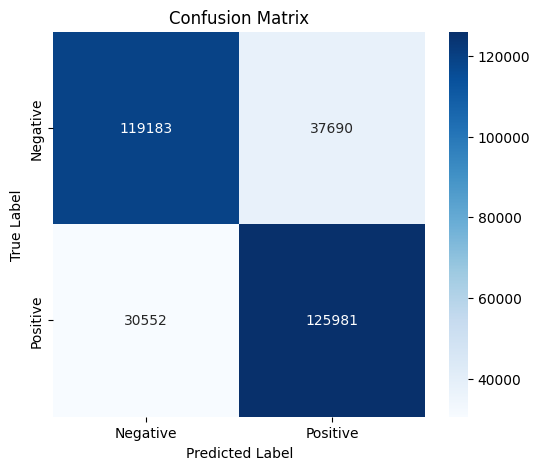

In [45]:
cfm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cfm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative' , 'Positive'], yticklabels=['Negative' , 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### SVM Classifier

In [ ]:
from sklearn.svm import LinearSVC
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

# Classification metrics
print("SVM Results")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
print("Accuracy:", accuracy_score(y_test, y_pred))

SVM Results
              precision    recall  f1-score   support

    Negative       0.80      0.75      0.78    156873
    Positive       0.77      0.81      0.79    156533

    accuracy                           0.78    313406
   macro avg       0.78      0.78      0.78    313406
weighted avg       0.78      0.78      0.78    313406

Accuracy: 0.7816889274615036


## Deep Learning

## Modify Preprocessing<br>
Remove the following steps from the original preprocessing<br>
<ol>
<li>Stopwords - LSTM learns from context</li>
<li>Lemmatization - LSTM benefits from full forms</li>
</ol>


In [46]:
def preprocess_lstm_text(text):
    # 1. Remove mentions (@user)
    text = re.sub(r'@\w+', '', text)

    # 2. Replace hashtags: keep word, remove #
    text = re.sub(r'#(\w+)', r'\1', text)

    # 3. Remove URLs
    text = re.sub(r'(https?://\S+|www\.\S+)', '', text)

    # 4. Lowercase
    text = text.lower()

    # 6. Remove numbers
    text = re.sub(r'\d+', '', text)

    # 7. Strip the space
    text = text.strip()

    return text


In [47]:
df['text_lstm'] = df['text'].progress_apply(preprocess_lstm_text)

100%|██████████| 1567030/1567030 [00:14<00:00, 107479.44it/s]


In [48]:
print (f"Original Text: {df['text'].iloc[0]}")
print (f"Preprocessed Text: {preprocess_lstm_text(df['text'].iloc[0])}")

Original Text: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
Preprocessed Text: - awww, that's a bummer.  you shoulda got david carr of third day to do it. ;d


### Import GloVe pretrained embeddings

In [49]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-04-03 06:20:14--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-03 06:20:14--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-03 06:20:14--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [50]:
import numpy as np
embedding_index = {}

with open("glove.6B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

print(f"Loaded {len(embedding_index)} word vectors.")

Loaded 400000 word vectors.


In [51]:
# Using a set to accumulate unique tokens
vocab = set()

# Iterate over each tweet in the 'text_lstm' column
for tweet in tqdm(df['text_lstm']):
    tokens = tweet.split()  # assuming tokens are separated by whitespace
    vocab.update(tokens)

# Get the vocabulary size
vocab_size = len(vocab)
print("\nVocabulary size:", vocab_size)

100%|██████████| 1567030/1567030 [00:05<00:00, 267047.38it/s]


Vocabulary size: 713589


In [52]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Parameters for LSTM
vocab_size = 400000  # Based on the dataset's vocabulary
max_len = 100  # Adjust based on your average tweet length
embedding_dim = 100  # Dimensionality of word embeddings

# Tokenizer setup for LSTM
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(df['text_lstm'])  # Fit tokenizer on preprocessed text

# Convert the text to sequences (convert words to integers)
sequences = tokenizer.texts_to_sequences(df['text_lstm'])

# Pad sequences to make sure all sequences have the same length
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Labels (targets)
labels = df['target'].values

# Split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, stratify=labels, random_state=42)

In [ ]:
embedding_dim = 100  # Must match the GloVe file used
word_index = tokenizer.word_index
num_words = min(vocab_size, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= vocab_size:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### LSTM Training

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, LayerNormalization

model = Sequential([
    Embedding(
        input_dim=num_words,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=True  # Fine-tune GloVe
    ),

    Bidirectional(LSTM(64, return_sequences=True)),  # Reduced from 128
    LayerNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(32)),  # Reduced from 64
    LayerNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),  # Reduced from 64
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])


In [ ]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=1e-3)  # Try lowering from default 1e-3
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_schedule = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=15,  # give more room to improve
    batch_size=1024,
    callbacks=[early_stop]
)


Epoch 1/15
980/980 ━━━━━━━━━━━━━━━━━━━━ 118s 113ms/step - accuracy: 0.7347 - loss: 0.5222 - val_accuracy: 0.8115 - val_loss: 0.4123
Epoch 2/15
980/980 ━━━━━━━━━━━━━━━━━━━━ 112s 114ms/step - accuracy: 0.8225 - loss: 0.3958 - val_accuracy: 0.8196 - val_loss: 0.4011
Epoch 3/15
980/980 ━━━━━━━━━━━━━━━━━━━━ 139s 111ms/step - accuracy: 0.8468 - loss: 0.3511 - val_accuracy: 0.8209 - val_loss: 0.4032
Epoch 4/15
980/980 ━━━━━━━━━━━━━━━━━━━━ 109s 111ms/step - accuracy: 0.8629 - loss: 0.3188 - val_accuracy: 0.8145 - val_loss: 0.4244
Epoch 5/15
980/980 ━━━━━━━━━━━━━━━━━━━━ 143s 112ms/step - accuracy: 0.8757 - loss: 0.2899 - val_accuracy: 0.8163 - val_loss: 0.4442


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

y_pred = (model.predict(X_test) > 0.5).astype("int32")
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

9794/9794 ━━━━━━━━━━━━━━━━━━━━ 87s 9ms/step - accuracy: 0.8209 - loss: 0.3998
Test Accuracy: 0.8202
9794/9794 ━━━━━━━━━━━━━━━━━━━━ 71s 7ms/step
              precision    recall  f1-score   support

    Negative       0.82      0.82      0.82    156873
    Positive       0.82      0.82      0.82    156533

    accuracy                           0.82    313406
   macro avg       0.82      0.82      0.82    313406
weighted avg       0.82      0.82      0.82    313406



#### Save the model to Google Drive

In [ ]:
!mkdir "/content/drive/MyDrive/lstm/"

In [ ]:
 model.save('/content/drive/MyDrive/lstm/lstm_sentiment_model.keras')

In [ ]:
import pickle

# Save tokenizer
with open('/content/drive/MyDrive/lstm/tokenizer_lstm.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

### Model Inference

In [53]:
!wget https://www.dropbox.com/scl/fi/bmnorr7o43b9h0l5h3qln/lstm.zip?rlkey=ugns31p0be5r0ru1g6kn4zg2c&st=ojwj9oln&dl=1

--2025-04-03 06:30:44--  https://www.dropbox.com/scl/fi/bmnorr7o43b9h0l5h3qln/lstm.zip?rlkey=ugns31p0be5r0ru1g6kn4zg2c
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5bc2e0fc67715abb0e8631f2bc.dl.dropboxusercontent.com/cd/0/inline/CnEk8bXjpL8l_UBLD3rkllxdgD17SGFs3o0t_R4weuDVz6UAQG6MThSvw8FfLLKE5ip9RfDHWIuKflvfcSSLA-CfSUt-qCsBSLIr7YZ-8AC6sh-h52GElI8KPF58AZFVIvQ/file# [following]
--2025-04-03 06:30:44--  https://uc5bc2e0fc67715abb0e8631f2bc.dl.dropboxusercontent.com/cd/0/inline/CnEk8bXjpL8l_UBLD3rkllxdgD17SGFs3o0t_R4weuDVz6UAQG6MThSvw8FfLLKE5ip9RfDHWIuKflvfcSSLA-CfSUt-qCsBSLIr7YZ-8AC6sh-h52GElI8KPF58AZFVIvQ/file
Resolving uc5bc2e0fc67715abb0e8631f2bc.dl.dropboxusercontent.com (uc5bc2e0fc67715abb0e8631f2bc.dl.dropboxusercontent.com)... 162.125.3.15, 2620:100:6018:15::a27d:30f
Connecting to uc5bc2e0fc6

In [54]:
!unzip lstm.zip

Archive:  lstm.zip
  inflating: lstm/tokenizer_lstm.pkl  
  inflating: lstm/lstm_sentiment_model.keras  


In [55]:
from keras.models import load_model

model_loaded = load_model('/content/lstm/lstm_sentiment_model.keras')

In [56]:
import pickle

# Load tokenizer
with open('/content/lstm/tokenizer_lstm.pkl', 'rb') as f:
    tokenizer = pickle.load(f)


In [57]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_sentiment_lstm(text, max_len = 100):
    # Preprocess the text
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')

    # Predict probability
    prob = model_loaded.predict(padded)[0][0]

    # Format as percentage
    confidence = round(prob * 100, 2)

    # Classify sentiment
    if prob >= 0.5:
        sentiment = "Positive"
    else:
        sentiment = "Negative"
        confidence = 100 - confidence  # flip confidence if negative

    return f"{confidence:.4f}% {sentiment}"


In [ ]:
predict_sentiment_lstm("Very happy today Its my birthday Too much excited #happy")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


'98.4500% Negative'

### BERT Model

In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import BertTokenizerFast, BertForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch

In [ ]:
## Skip this code if you already have tokenizer saved once ##
# Convert to Hugging Face Dataset
dataset = Dataset.from_pandas(df[['text', 'target']])

# Tokenize
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

def tokenize_function(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=100)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.rename_column("target", "labels")
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Step 4: Train/test split
train_test = tokenized_dataset.train_test_split(test_size=0.2)
train_dataset = train_test['train']
test_dataset = train_test['test']


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/1567030 [00:00<?, ? examples/s]

#### Save the Tokenizer

In [ ]:
!mkdir "/content/drive/MyDrive/bert/"

In [ ]:
from datasets import DatasetDict

# Tokenized dataset (train/test)
train_test = tokenized_dataset.train_test_split(test_size=0.2)
train_dataset = train_test['train']
test_dataset = train_test['test']

# Wrap in DatasetDict so you can save both together
dataset_dict = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

# Save to disk (as arrow file format)
dataset_dict.save_to_disk("/content/drive/MyDrive/bert/tokenized_bert_dataset")


Saving the dataset (0/2 shards):   0%|          | 0/1253624 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/313406 [00:00<?, ? examples/s]

#### Load the Tokenizer

In [ ]:
from datasets import load_from_disk

# Load dataset from disk
dataset_dict = load_from_disk("/content/drive/MyDrive/bert/tokenized_bert_dataset")
train_dataset = dataset_dict["train"]
test_dataset = dataset_dict["test"]

In [ ]:
# Tokenize
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

#### Load Pretrained Models

In [ ]:
from transformers import DistilBertForSequenceClassification
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Metrics Function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.argmax(torch.tensor(logits), dim=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

#### Training

In [ ]:
# TrainingArguments
training_args = TrainingArguments(
    output_dir="./bert_output",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=256,
    per_device_eval_batch_size=512,
    fp16=True,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-32-405d575130b7>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Train
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.318400,0.313348,0.864374,0.867833,0.845374,0.891517
2,0.270600,0.303579,0.870124,0.870843,0.865112,0.876651
3,0.226000,0.322286,0.869205,0.868311,0.873317,0.863363


TrainOutput(global_step=14691, training_loss=0.2813477114022496, metrics={'train_runtime': 7500.3576, 'train_samples_per_second': 501.426, 'train_steps_per_second': 1.959, 'total_flos': 9.73033067418336e+16, 'train_loss': 0.2813477114022496, 'epoch': 3.0})

In [ ]:


# Step 10: Evaluate
trainer.evaluate()

# Step 11: Save model
trainer.save_model("/content/drive/MyDrive/bert/bert_sentiment_model")
tokenizer.save_pretrained("/content/drive/MyDrive/bert/bert_sentiment_model")


('/content/drive/MyDrive/bert/bert_sentiment_model/tokenizer_config.json',
 '/content/drive/MyDrive/bert/bert_sentiment_model/special_tokens_map.json',
 '/content/drive/MyDrive/bert/bert_sentiment_model/vocab.txt',
 '/content/drive/MyDrive/bert/bert_sentiment_model/added_tokens.json',
 '/content/drive/MyDrive/bert/bert_sentiment_model/tokenizer.json')

### Load the Model

In [62]:
!wget https://www.dropbox.com/scl/fi/sb5pjgpmvcgstb870nspa/bert.zip?rlkey=95fwfll66t407qjzuz2r2vwj8&st=nshccini&dl=1

--2025-04-03 06:34:31--  https://www.dropbox.com/scl/fi/sb5pjgpmvcgstb870nspa/bert.zip?rlkey=95fwfll66t407qjzuz2r2vwj8
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc67dac02e9c36c44460ed9a8553.dl.dropboxusercontent.com/cd/0/inline/CnFo7GlAtgdNQCVhSfLPLoGKDT9_uilUVPyDb4N0jm-l6TdlZ-UzW_JXh_fY9lidjtR1jLPYQpCWlIvO_cL-S01mgGU-7BaCBNnUoQH7dxd6CWqUG0K9mdkR-yi0SOY-ih4/file# [following]
--2025-04-03 06:34:31--  https://uc67dac02e9c36c44460ed9a8553.dl.dropboxusercontent.com/cd/0/inline/CnFo7GlAtgdNQCVhSfLPLoGKDT9_uilUVPyDb4N0jm-l6TdlZ-UzW_JXh_fY9lidjtR1jLPYQpCWlIvO_cL-S01mgGU-7BaCBNnUoQH7dxd6CWqUG0K9mdkR-yi0SOY-ih4/file
Resolving uc67dac02e9c36c44460ed9a8553.dl.dropboxusercontent.com (uc67dac02e9c36c44460ed9a8553.dl.dropboxusercontent.com)... 162.125.3.15, 2620:100:6018:15::a27d:30f
Connecting to uc67dac02e9

In [63]:
!unzip bert.zip

Archive:  bert.zip
  inflating: bert/bert_sentiment_model/vocab.txt  
  inflating: bert/bert_sentiment_model/config.json  
  inflating: bert/bert_sentiment_model/special_tokens_map.json  
  inflating: bert/bert_sentiment_model/tokenizer_config.json  
  inflating: bert/tokenized_bert_dataset/test/dataset_info.json  
  inflating: bert/bert_sentiment_model/tokenizer.json  
  inflating: bert/tokenized_bert_dataset/dataset_dict.json  
  inflating: bert/tokenized_bert_dataset/train/dataset_info.json  
  inflating: bert/bert_sentiment_model/training_args.bin  
  inflating: bert/tokenized_bert_dataset/train/state.json  
  inflating: bert/tokenized_bert_dataset/test/state.json  
  inflating: bert/tokenized_bert_dataset/test/data-00000-of-00001.arrow  
  inflating: bert/bert_sentiment_model/model.safetensors  
  inflating: bert/tokenized_bert_dataset/train/data-00000-of-00002.arrow  
  inflating: bert/tokenized_bert_dataset/train/data-00001-of-00002.arrow  


In [64]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

# Load model and tokenizer from Drive
model_path = "/content/bert/bert_sentiment_model"
# tokenizer_path = "/content/bert/tokenized_bert_dataset"

tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)

# Move model to GPU if available
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizerFast'.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [65]:
def predict_sentiment_bert(text):
    # Tokenize input
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=64)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get prediction
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)[0]

    # Determine label + confidence
    pred_class = torch.argmax(probs).item()
    confidence = round(probs[pred_class].item() * 100, 2)

    sentiment = "Positive" if pred_class == 1 else "Negative"
    return f"{confidence:.4f}% {sentiment}"

In [67]:
predict_sentiment_bert("Very Fun day Too excited for the match")

'98.1100% Positive'